## Final Project Submission

Please fill out: 
* Student name: **Alberto SYLVEUS** 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: **Wedter JEROME**
*  
[Click here to get the github repository](https://github.com/tolly00/dsc-phase2-myproject.git)


## Overview

In this project, we will use exploratory data analysis to generate insight for a business stackholder. 

## Business Understanding

After seing all the big company creating original video content and the want ti get in on the fun. A company has decided to create a new movie studio, but the personal doesn't know anything about creating movies. So we are going to exploring what types of films are currently doing the best at the box office. we will translate those findings into actionable insights that the head of the company's new movie studio can use to help decide what type of films to create.

## Data Understanding

* We have data from various locations, the different files have different formats. Some are compressed CSV(comma-separated values) or TSV(tab-separated values) files that can be opened using spreadsheet software or `pd.read_csv`, whith the data from IMDB is located in a SQLite database. In this case all those data are zippep in a folder that called `zippedData`, we will use `file explorer` to unzip them. Right now those files are ready to use.

    The goal of this analysis is to identify what types of films are currently doing the best at the box office to help the company's new movie studio about their decisions to create movie.

* In `zippedData` we are going to use `im.db` file. This is a sqlite database file. This database has 8 tables: movies_basics, directors, known_for, movies_akas, movies_rating, persons, principals, writers.
* The tables that have relevant data to make this analysis possible is: **movie_basics** and **movie_rating**.

  - **movie_basics:** has data about title, runtime, genres, etc...
  - **movie_rating**: has data about average rating and number of votes
  - l
* So let's see which genres get the most audience engagement(number of votes)?
* What genres get the most appreciation (more rating)?
* What is the best types accordingly both parameters, audience and liked?


## Data Preparation

In [1]:
# import necessary modules
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
# connect to the database
path = "zippedData/im.db"
conn = sqlite3.connect(path)
q = """
    SELECT name
    FROM sqlite_master
    WHERE type = "table"
    """
pd.read_sql(q,conn) #show all tables name of the database

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


Let's use `movie_basics` and `movie_rating` tables to create a view.To avoid compromizing our analysis, we drop rows with NaN values.

In [3]:
# join them together
q = """
    CREATE VIEW IF NOT EXISTS movies AS
    SELECT
    b.movie_id, b.primary_title, b.start_year, b.genres, b.runtime_minutes, r.averagerating, r.numvotes 
    FROM movie_basics AS b
    JOIN movie_ratings AS r
    USING (movie_id)
    WHERE 
    b.genres IS NOT NULL AND b.genres != ''
    AND b.runtime_minutes IS NOT NULL
    AND r.averagerating IS NOT NULL
    AND r.numvotes IS NOT NULL;
    """
conn.execute(q)
conn.commit()

In [4]:
# show the movies view
q = """
SELECT * FROM movies;
"""
df_movies = pd.read_sql(q,conn)
df_movies.head()

,movie_id,primary_title,start_year,genres,runtime_minutes,averagerating,numvotes
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama",175.0,7.0,77
1,tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama",114.0,7.2,43
2,tt0069049,The Other Side of the Wind,2018,Drama,122.0,6.9,4517
3,tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",80.0,6.5,119
4,tt0137204,Joe Finds Grace,2017,"Adventure,Animation,Comedy",83.0,8.1,263


In [5]:
# A quickly preview on data after cleaning
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65720 entries, 0 to 65719
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65720 non-null  object 
 1   primary_title    65720 non-null  object 
 2   start_year       65720 non-null  int64  
 3   genres           65720 non-null  object 
 4   runtime_minutes  65720 non-null  float64
 5   averagerating    65720 non-null  float64
 6   numvotes         65720 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 3.5+ MB


## Analysis and results

We are going to work on the dataset to see what types of films are doing the best at the box office.

In [6]:
df_movies.head()

,movie_id,primary_title,start_year,genres,runtime_minutes,averagerating,numvotes
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama",175.0,7.0,77
1,tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama",114.0,7.2,43
2,tt0069049,The Other Side of the Wind,2018,Drama,122.0,6.9,4517
3,tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",80.0,6.5,119
4,tt0137204,Joe Finds Grace,2017,"Adventure,Animation,Comedy",83.0,8.1,263


In the `genres` column we can see certains of films have multiples genres. we are going to make a split on it to help us grouping by `genres`.

In [7]:
df_movies['genres'] = df_movies['genres'].str.split(',') # split comma-separated genres into lists

In [8]:
df_exploded = df_movies.explode('genres') # explode the list into separate rows

In [9]:
df_exploded.info() # a quickly preview of the dataset update.

<class 'pandas.core.frame.DataFrame'>
Index: 118437 entries, 0 to 65719
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         118437 non-null  object 
 1   primary_title    118437 non-null  object 
 2   start_year       118437 non-null  int64  
 3   genres           118437 non-null  object 
 4   runtime_minutes  118437 non-null  float64
 5   averagerating    118437 non-null  float64
 6   numvotes         118437 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 7.2+ MB


In [10]:
# group data by genres sort by numvotes
genre_votes = df_exploded.groupby('genres')['numvotes'].sum().sort_values(ascending=False).head(10)
genre_votes

genres
Drama        119452909
Action       101126583
Adventure     84222953
Comedy        74181319
Thriller      48126681
Sci-Fi        42955302
Crime         39618088
Romance       26875313
Fantasy       26326977
Mystery       24649959
Name: numvotes, dtype: int64

Here we sort genres by `numvotes`. numvotes is the column that show us the numbers of people that whatch the movie. Where we consider this option the top 5 of the best types of movies at the box offices are: **Drama, Action, Adventure, Comedy, Thriller.**

For example, let's take a look at the top 10 `films` by popularity votes.

In [11]:
top_numvotes = """
SELECT *
FROM movies
ORDER BY numvotes DESC
LIMIT 20;
"""
df_top_numvotes = pd.read_sql(top_numvotes,conn).head(10)
df_top_numvotes

,movie_id,primary_title,start_year,genres,runtime_minutes,averagerating,numvotes
0,tt1375666,Inception,2010,"Action,Adventure,Sci-Fi",148.0,8.8,1841066
1,tt1345836,The Dark Knight Rises,2012,"Action,Thriller",164.0,8.4,1387769
2,tt0816692,Interstellar,2014,"Adventure,Drama,Sci-Fi",169.0,8.6,1299334
3,tt1853728,Django Unchained,2012,"Drama,Western",165.0,8.4,1211405
4,tt0848228,The Avengers,2012,"Action,Adventure,Sci-Fi",143.0,8.1,1183655
5,tt0993846,The Wolf of Wall Street,2013,"Biography,Crime,Drama",180.0,8.2,1035358
6,tt1130884,Shutter Island,2010,"Mystery,Thriller",138.0,8.1,1005960
7,tt2015381,Guardians of the Galaxy,2014,"Action,Adventure,Comedy",121.0,8.1,948394
8,tt1431045,Deadpool,2016,"Action,Adventure,Comedy",108.0,8.0,820847
9,tt1392170,The Hunger Games,2012,"Action,Adventure,Sci-Fi",142.0,7.2,795227


In [12]:
# group data by genres sort by average rating
genre_avgrating = df_exploded.groupby('genres')['averagerating'].mean().sort_values(ascending=False).head(10)
genre_avgrating

genres
Short          8.800000
Documentary    7.316787
Game-Show      7.300000
News           7.278783
Biography      7.169185
Music          7.070662
History        7.048928
Sport          6.964604
Reality-TV     6.600000
War            6.573962
Name: averagerating, dtype: float64

When we consider sorting by `averagerating`. average rating help us to know how the movie is appreciated. so a movie can have a lot of watching and people don't like it. if we want to know about the appreciation we have to look at the average rating. According that the top 5 of the best types of films are: **Short, Documentary, Game-Show, News, Biography.**

Let's see about the top 10 by `averagerating`.

In [13]:
top_avgrating = """
SELECT *
FROM movies
ORDER BY averagerating DESC
LIMIT 10;
"""
df_top_avgrating = pd.read_sql(top_avgrating,conn).head(10)
df_top_avgrating

,movie_id,primary_title,start_year,genres,runtime_minutes,averagerating,numvotes
0,tt10176328,Exteriores: Mulheres Brasileiras na Diplomacia,2018,Documentary,52.0,10.0,5
1,tt10378660,The Dark Knight: The Ballad of the N Word,2018,"Comedy,Drama",129.0,10.0,5
2,tt1770682,Freeing Bernie Baran,2010,"Crime,Documentary",100.0,10.0,5
3,tt2632430,Hercule contre Hermès,2012,Documentary,72.0,10.0,5
4,tt4109192,I Was Born Yesterday!,2015,Documentary,31.0,10.0,6
5,tt4960818,Revolution Food,2015,Documentary,70.0,10.0,8
6,tt5089804,Fly High: Story of the Disc Dog,2019,Documentary,65.0,10.0,7
7,tt5390098,The Paternal Bond: Barbary Macaques,2015,Documentary,59.0,10.0,5
8,tt6295832,Requiem voor een Boom,2016,Documentary,48.0,10.0,5
9,tt6991826,A Dedicated Life: Phoebe Brand Beyond the Group,2015,Documentary,93.0,10.0,5


### Business Recommendation 1: Work on High performing hibrid genres.

We can see genres like **drama, action,adventure, comedy and thriller** tend to attract a high number of votes, that means they have large audience and have strong box office potential. So if we combine elements from multiple categories, for example: the film that called **Inception** combine **action, adventure and sci-fi** together and it becomes the most popular movies at the box office. We can do the same.

### Business Recommendation 2: Invest in high average rating genre to build studio's brand

Genres like **documentary, news, short, game-show and biography** have higher average ratings, they are interested to people that are more critically respected and enjoyed by thoughful viewers. 
we recommend to create a smaller quantity, story-driven films in this genres. use the to develop the new studio brand and attract talent.

### Business Recommendation 3 : Explore Niche Crossovers with High Ratings and Growing Appeal

Hybrid genres like **Fantasy Drama or Mystery Sci-Fi** are showing strong ratings and increasing audience interest. By blending successful genres in creative ways, your studio can tap into fresh storytelling opportunities. Partnering with streaming platforms and tracking emerging trends will help reach targeted audiences and build momentum in these rising niches.

### Vizualisation

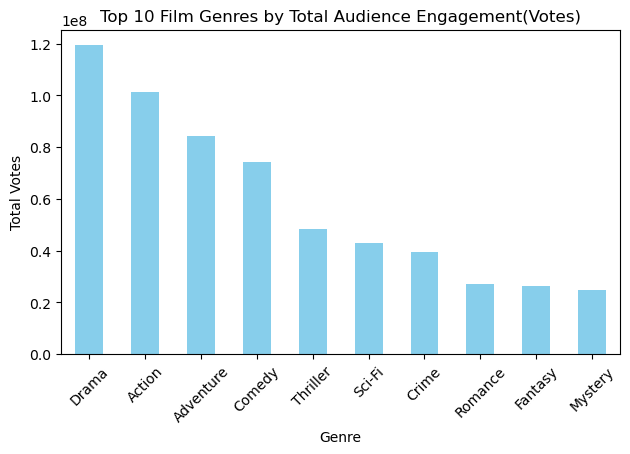

In [14]:
genre_votes.plot(kind='bar', color='skyblue')
plt.title("Top 10 Film Genres by Total Audience Engagement(Votes)")
plt.ylabel("Total Votes")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

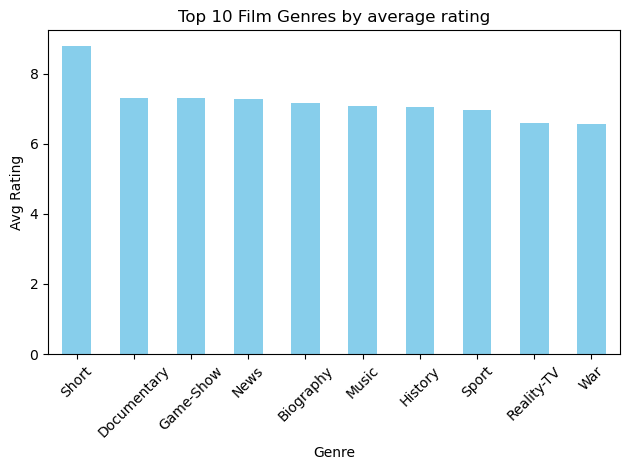

In [15]:
genre_avgrating.plot(kind='bar', color='skyblue')
plt.title("Top 10 Film Genres by average rating")
plt.ylabel("Avg Rating")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

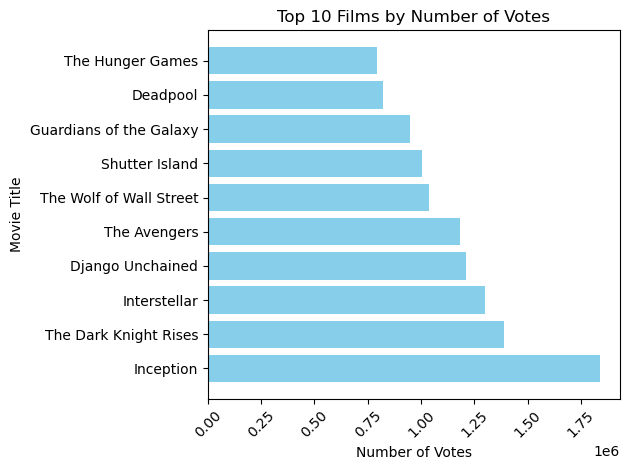

In [16]:

plt.barh(df_top_numvotes['primary_title'], df_top_numvotes['numvotes'], color='skyblue')
plt.title('Top 10 Films by Number of Votes')
plt.xlabel('Number of Votes')
plt.xticks(rotation=45)
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()

## Conclusion

After analyzing both audience engagement (number of votes) and audience appreciation (average rating), we find that the films performing best at the box office typically fall into a few key genre categories. **Drama, Action, Adventure, Comedy and Thriller genres** consistently receive the highest number of votes, indicating mass appeal and strong box office potential. At the same time, genres like **Documentary, short, Game-show and well-executed hybrid genres** tend to earn higher average ratings, reflecting deeper viewer satisfaction and long-term value.

Therefore, films that combine high-energy storytelling with emotional or intellectual depth (such as Action-Drama or Sci-Fi-Thriller) are especially well-positioned to succeed both commercially and critically. Studios should strategically balance blockbuster appeal with strong narratives, and explore rising hybrid genres to capture evolving audience tastes in a competitive market.